In [25]:
%reload_ext autoreload
%autoreload 2

import corner
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline   

from models_streams import *
from models_orbits import *
from priors import *
from utils import *
from mock_data import *
from likelihoods import *
from dynesty_fit import dynesty_fit

### First, generate Orbit Data and fit with Oribt ###

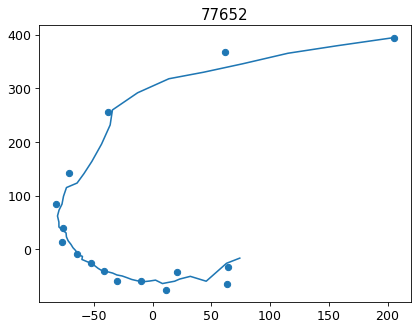

In [2]:
q_true = 1
ndim = 16
seed = np.random.randint(0, 100000)
nlive = 1000
data_type = 'stream'
model_type='orbit'
dict_data, params_data, spline_data, theta_track_data = get_mock_data(q_true, ndim, track=data_type, seed=seed, sigma=10, n_ang=72, min_particle=3, max_dist=80)

plt.title(seed)
plt.scatter(dict_data['x'], dict_data['y'])

r_track_data = spline_data(theta_track_data)
x_track_data = r_track_data * np.cos(theta_track_data)
y_track_data = r_track_data * np.sin(theta_track_data)
plt.plot(x_track_data, y_track_data)

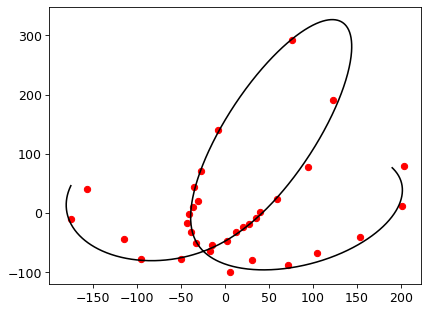

In [21]:
q_true = 1.0
model = gala_orbit_model_ndim13
prior_trainsform = orbit_unrestricted_prior_transform_ndim13
model_spline = orbit_spline
ndim = 13
seed = np.random.randint(0, 100000)
dict_data, params_data, spline_data, theta_track_data = get_mock_data(q_true, 
                                                                        model,
                                                                        prior_trainsform,
                                                                        model_spline,
                                                                        ndim,
                                                                        seed=seed, sigma=10, n_ang=72, min_particle=3, max_dist=80)

plt.scatter(dict_data['x'], dict_data['y'], c='r')
r_track_data = spline_data(theta_track_data)
x_track_data = r_track_data * np.cos(theta_track_data)
y_track_data = r_track_data * np.sin(theta_track_data)
plt.plot(x_track_data, y_track_data, c='k')

In [26]:
dns = dynesty_fit(dict_data, 
                gala_orbit_model_ndim12,
                orbit_spline,
                model_log_likelihood,
                orbit_large_prior_transform_ndim12,
                ndim=12, nlive=1000)

5705it [02:00, 47.20it/s, batch: 0 | bound: 9 | nc: 101 | ncall: 301379 | eff(%):  1.887 | loglstar:   -inf < -777.140 <    inf | logz: -788.897 +/-    nan | dlogz: 622.390 >  0.010]     


KeyboardInterrupt: 

In [4]:
def plot_corner_from_path(path, oblate_prolate=False):
        params_data = np.loadtxt(f'{path}/params.txt')
        with open(f'{path}/dict_result.pkl', 'rb') as file:
                dns = pickle.load(file)
        with open(f'{path}/dict_data.pkl', 'rb') as file:
                dict_data = pickle.load(file)

        if oblate_prolate:
                plot_corner_oblate_prolate(dns, dict_data, params_data)
        else:
                plot_corner(dns, dict_data, params_data)

def orbit_plot_corner_ndim12(dns, model, dict_data, params_data):
        figure = corner.corner(dns['samps'], 
                                labels = [r'logM$_{halo}$', r'R_s', r'$q$', r'$\hat{x}$', r'$\hat{y}$', r'$\hat{z}$', 
                                        r'x$_0$', r'z$_0$', r'v', r'$\hat{v_x}$', r'$\hat{v_y}$', r'$\hat{v_z}$'],
                                color='blue',
                                quantiles=[0.16, 0.5, 0.84],
                                show_titles=True, 
                                title_kwargs={"fontsize": 16},
                                truths=params_data, 
                                truth_color='red')

        plt.figure(figsize=(15, 5))
        plt.subplot(1,2,1)
        plt.xlabel(r'x [kpc]')
        plt.ylabel(r'y [kpc]')
        x_model, y_model = model(dns['samps'][np.argmax(dns['logl'])]).T
        plt.plot(x_model, y_model, color='red', label='Orbit Model')
        x_data, y_data = model(params_data).T
        plt.plot(x_data, y_data, color='k', label='Orbit Data')
        plt.scatter(dict_data['x'], dict_data['y'], s=100, color='k', label='Stream Data')
        plt.legend(loc='best')
        plt.subplot(1,2,2)
        r_model = np.sqrt(x_model**2 + y_model**2)
        theta_model = np.arctan2(y_model, x_model)
        theta_model[theta_model < 0] += 2*np.pi
        theta_model = np.unwrap(theta_model)
        plt.plot(theta_model, r_model, color='red', label='Orbit Model')
        r_data = np.sqrt(x_data**2 + y_data**2)
        theta_data = np.arctan2(y_data, x_data)
        theta_data[theta_data < 0] += 2*np.pi
        theta_data = np.unwrap(theta_data)
        plt.plot(theta_data, r_data, color='k', label='Orbit Data')
        plt.scatter(dict_data['theta'], dict_data['r'], s=100, color='k', label='Stream Data')
        plt.legend(loc='best')

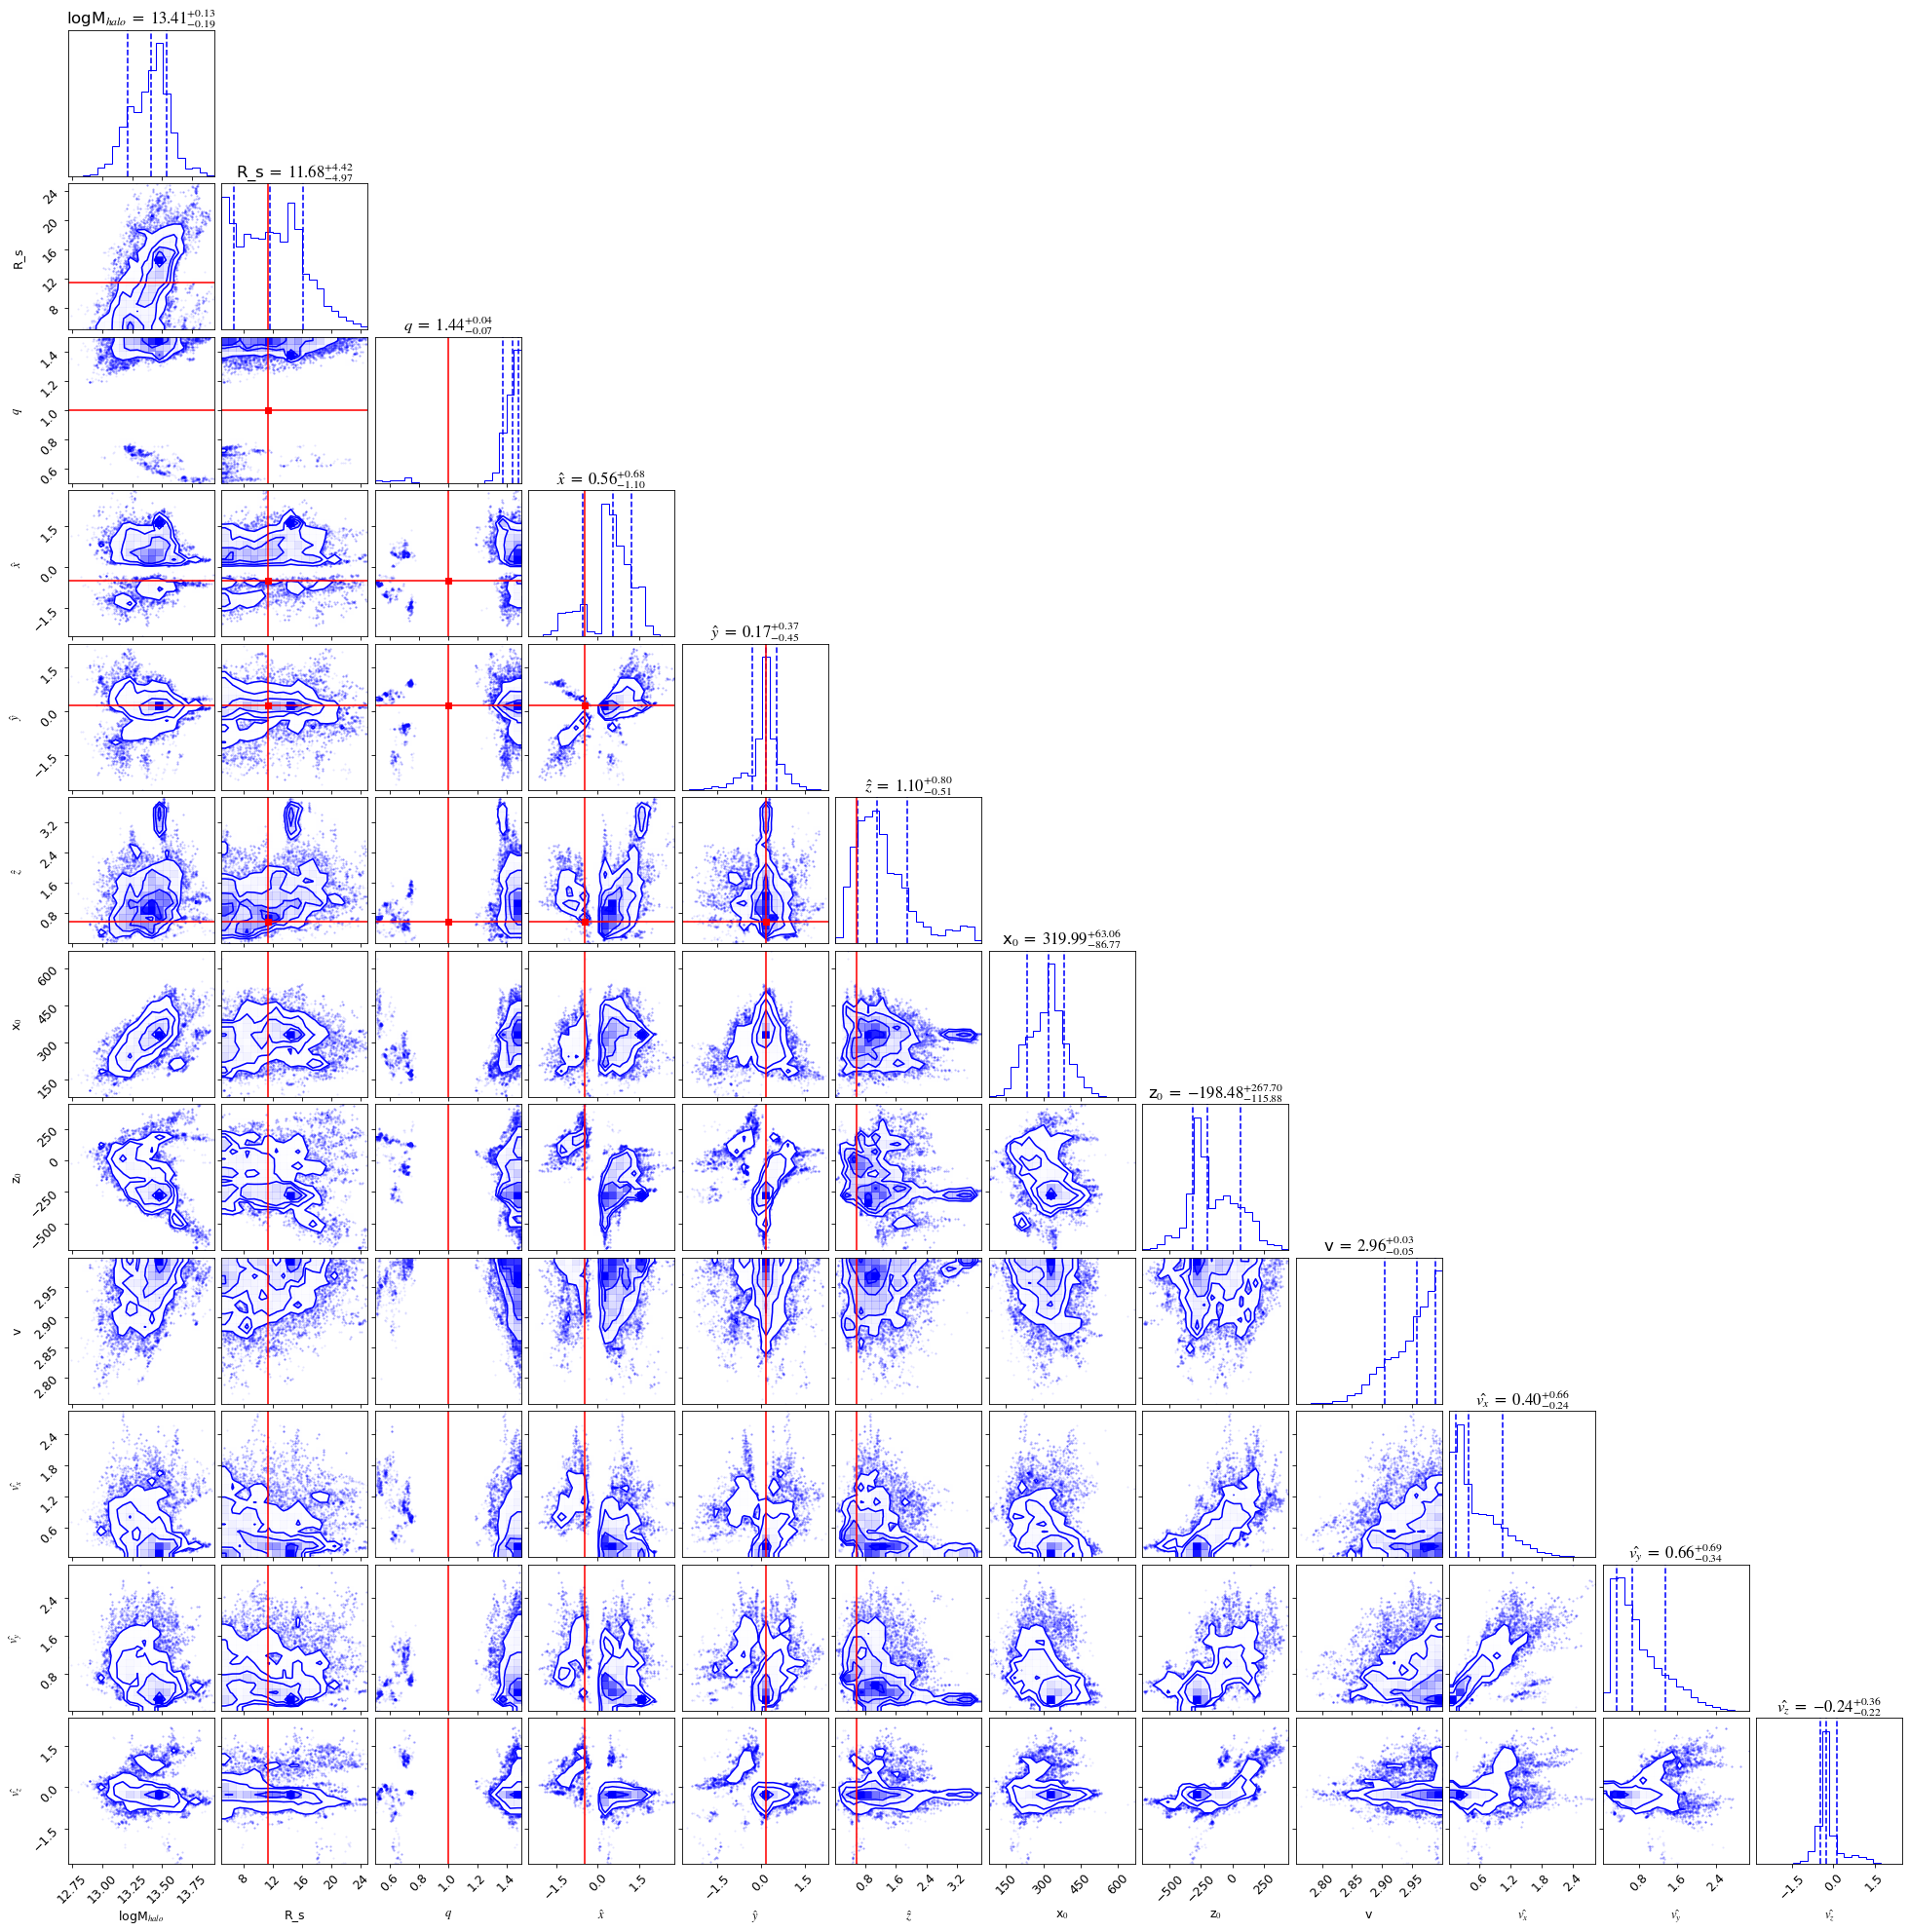

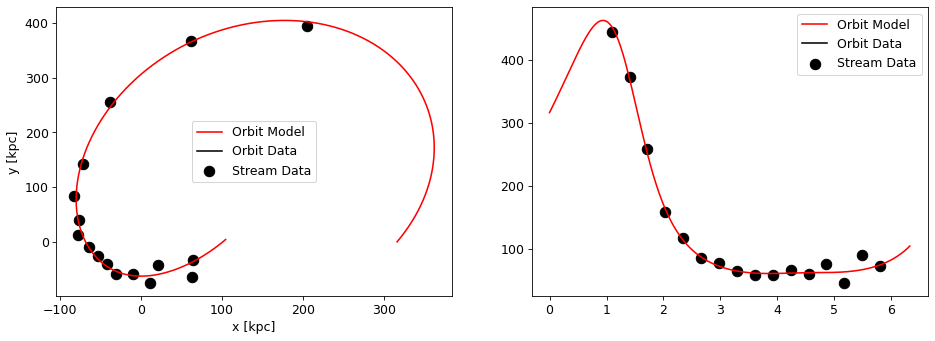

In [17]:
orbit_plot_corner_ndim12(dns, gala_stream_model_ndim12, dict_data, np.concatenate( [params_data[:6], np.zeros(6)+np.nan] ))

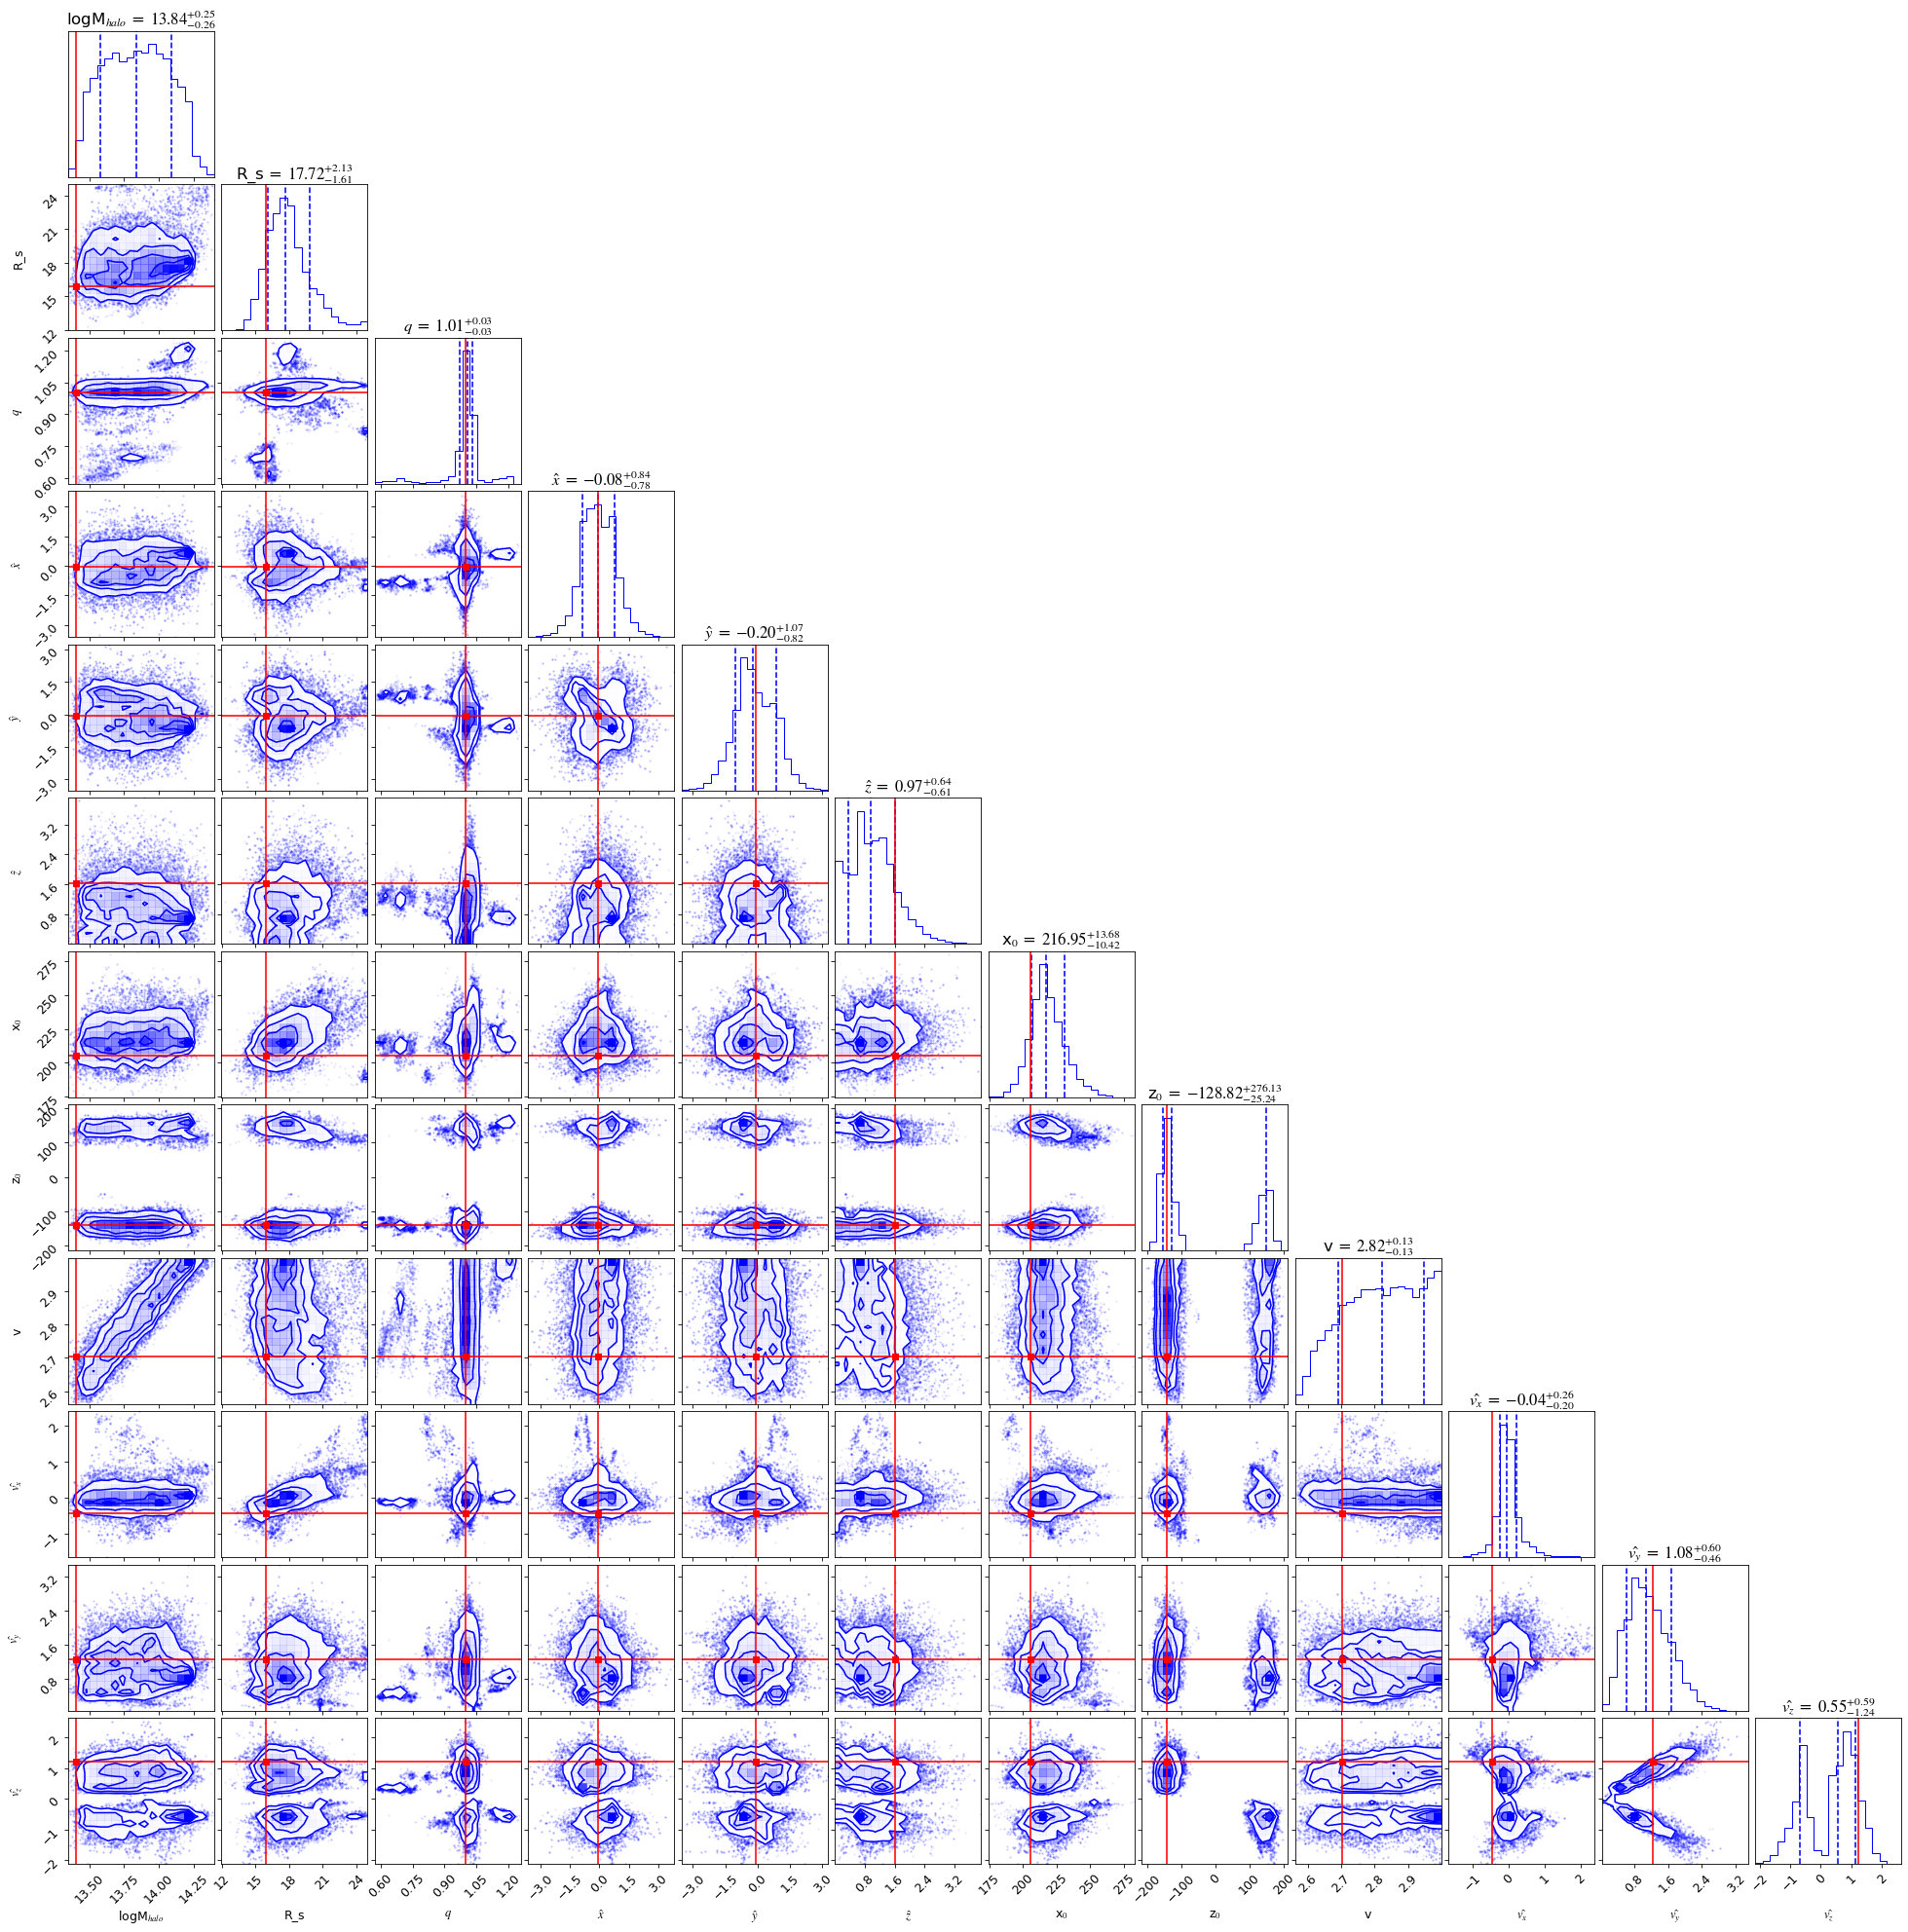

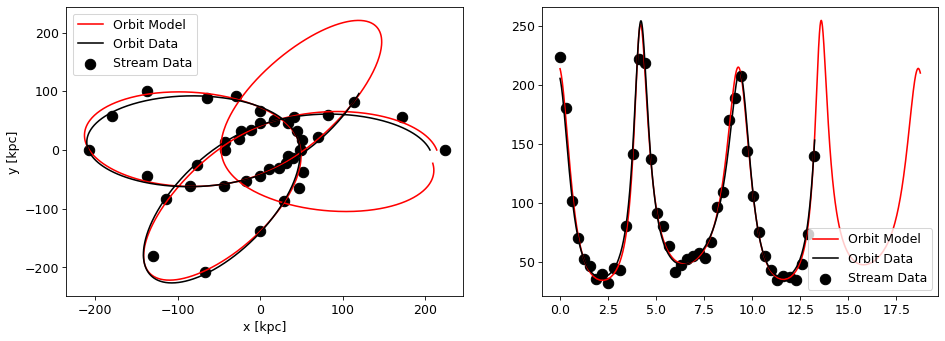

In [22]:
orbit_plot_corner_ndim12(dns, gala_stream_model_ndim12, dict_data, params_data)